# **Fraud detection using online payment data**

Dataset description:
I used a dataset from Kaggle, which contains historical data about fraudulent transactions which can be used to detect fraud in online payments. Below are all the columns from the dataset:

- step: represents a unit of time where 1 step equals 1 hour
- type: type of online transaction
- amount: the amount of the transaction
- nameOrig: customer starting the transaction
- oldbalanceOrg: balance before the transaction
- newbalanceOrig: balance after the transaction
- nameDest: recipient of the transaction
- oldbalanceDest: initial balance of recipient before the transaction
- newbalanceDest: the new balance of recipient after the transaction
- isFraud: fraud transaction

# Importing necessary libraries

In [130]:
import numpy as np
import pandas as pd
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/online-payments-fraud-detection-dataset/PS_20174392719_1491204439457_log.csv


In [131]:
import matplotlib.pyplot as plt
import seaborn as sns

In [132]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn import preprocessing, utils

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score, fbeta_score

# EDA & Cleaning

In [133]:
data = pd.read_csv('/kaggle/input/online-payments-fraud-detection-dataset/PS_20174392719_1491204439457_log.csv')

In [134]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [135]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [136]:
data.drop('isFlaggedFraud', axis=1, inplace=True)

In [137]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 10 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
dtypes: float64(5), int64(2), object(3)
memory usage: 485.4+ MB


In [138]:
data.shape

(6362620, 10)

In [139]:
data.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00


In [140]:
data.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
dtype: int64

In [141]:
data.duplicated().sum()

0

In [142]:
columns = data.columns
columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud'],
      dtype='object')

<Axes: >

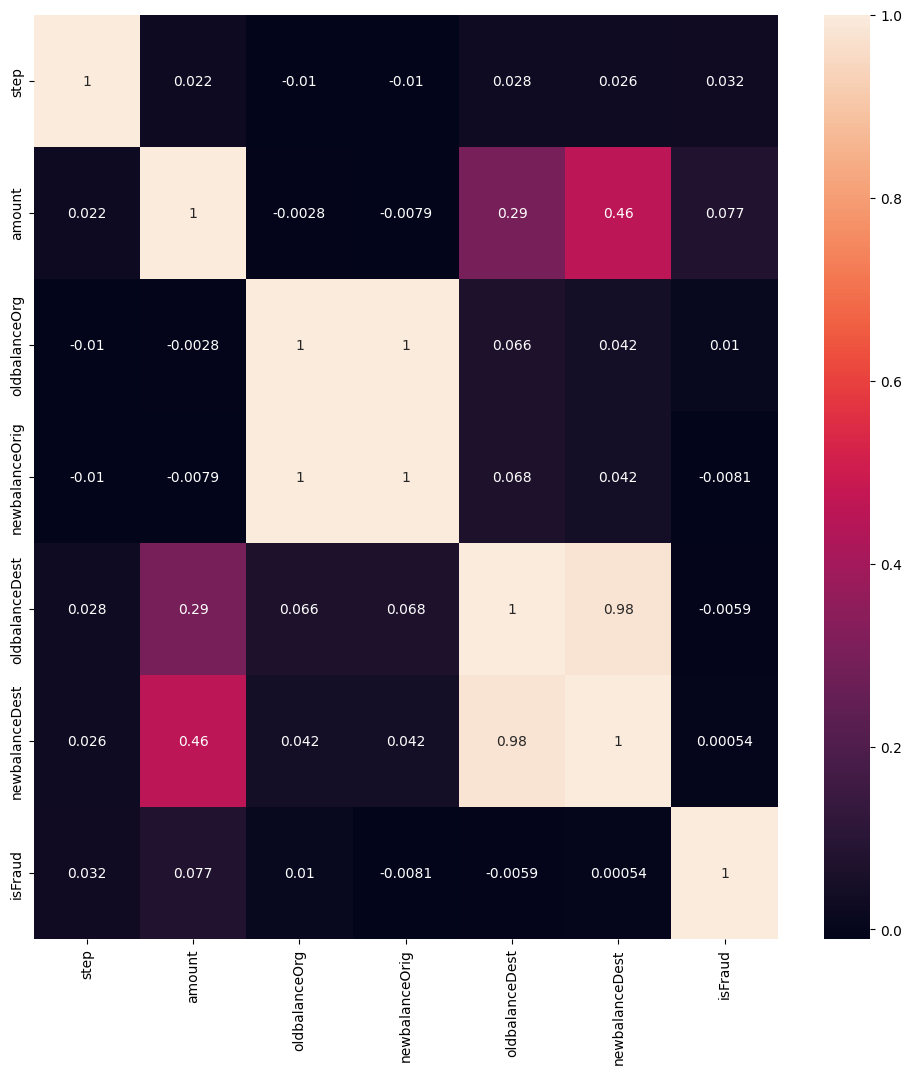

In [143]:
corr = data.select_dtypes(include=[np.number]).corr()
plt.figure(figsize=(12,12))
sns.heatmap(corr, annot=True)

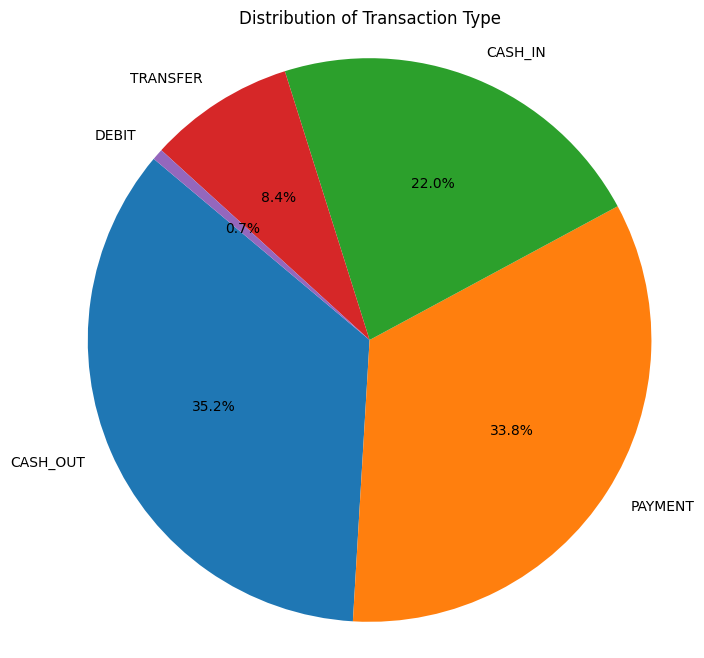

In [144]:
type_counts = data["type"].value_counts()
transactions = type_counts.index
quantity = type_counts.values

plt.figure(figsize=(8, 8))
plt.pie(quantity, labels=transactions, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Transaction Type')
plt.axis('equal')
plt.show()

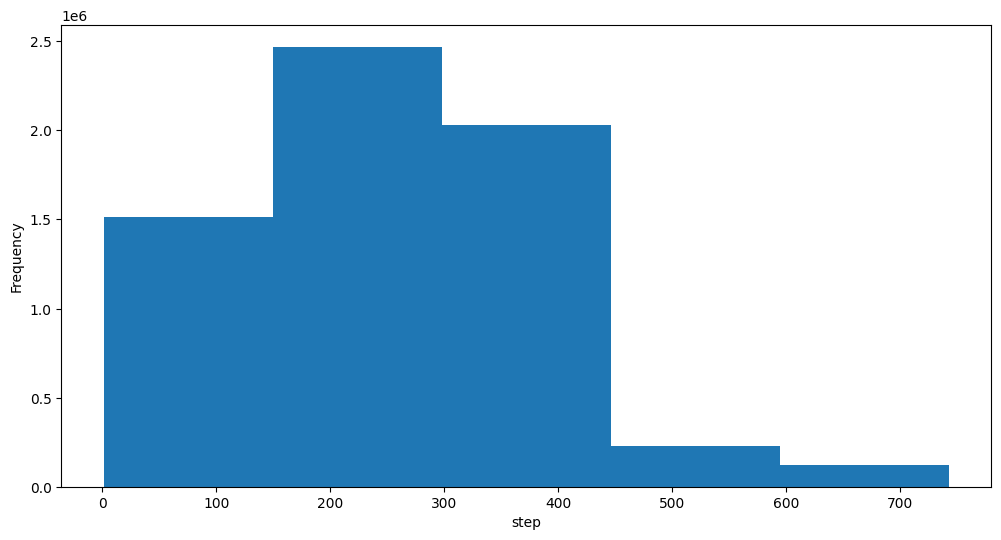

In [145]:
plt.figure(figsize=(12, 6))
plt.xlabel('step')
plt.ylabel('Frequency')
plt.hist(data['step'], bins=5)
plt.show()

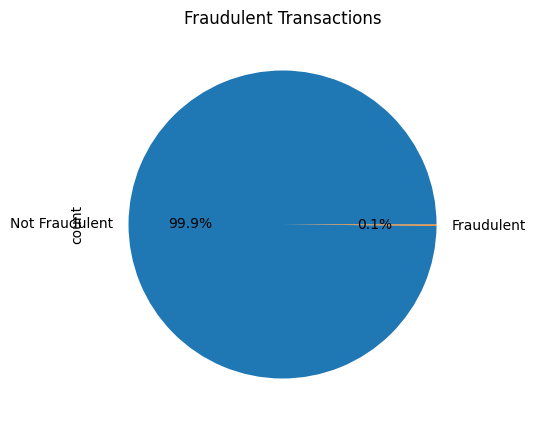

In [146]:
def assign_label(x):
    if x == 1:
        return "Fraudulent"
    else:
        return "Not Fraudulent"

data["fraud_label"] = data["isFraud"].apply(assign_label)

plt.figure(figsize=(10, 5))
plt.title("Fraudulent Transactions")
data["fraud_label"].value_counts().plot.pie(autopct='%1.1f%%')
plt.show()

In [147]:
data['isFraud'].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

Note: Dataset is not balaced

In [148]:
data.type.unique()

array(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'],
      dtype=object)

In [149]:
def remove_outliers(data, column_name):
    q1 = np.percentile(data[column_name], 25, interpolation='midpoint')
    q3 = np.percentile(data[column_name], 75, interpolation='midpoint')
    iqr = q3 - q1
    
    upper_bound = q3 + 1.5 * iqr
    lower_bound = q1 - 1.5 * iqr
    
    outliers_upper = np.where(data[column_name] >= upper_bound)
    outliers_lower = np.where(data[column_name] <= lower_bound)
    
    # Drop rows by index directly
    data_cleaned = data.drop(data.index[outliers_upper[0]])
    data_cleaned = data_cleaned.drop(data.index[outliers_lower[0]])
    
    return data_cleaned

data_cleaned = remove_outliers(data, 'amount')
class_count_not_fraud, class_count_fraud = data_cleaned['isFraud'].value_counts()

class_not_fraud = data_cleaned[data_cleaned['isFraud'] == 0]
class_fraud = data_cleaned[data_cleaned['isFraud'] == 1]

print('Class not fraud shape:', class_not_fraud.shape)
print('Class fraud shape:', class_fraud.shape)

/tmp/ipykernel_33/2518295359.py:18: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  data_cleaned = remove_outliers(data, 'amount')


Class not fraud shape: (6020184, 11)
Class fraud shape: (4359, 11)


***There is imbalance in the dataset***

In [150]:
class_not_fraud_under = class_not_fraud.sample(class_count_fraud)

balanced_data = pd.concat([class_not_fraud_under, class_fraud], axis=0)

print("Total count of each class after balancing:")
print(balancing_data['isFraud'].value_counts())

Total count of each class after balancing:
isFraud
0    4359
1    4359
Name: count, dtype: int64


In [151]:
balanced_data

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,fraud_label
4692485,331,PAYMENT,11445.94,C634424215,104160.00,92714.06,M539182894,0.00,0.00,0,Not Fraudulent
6264370,612,PAYMENT,10732.97,C22831374,52145.00,41412.03,M380737262,0.00,0.00,0,Not Fraudulent
1880984,164,CASH_OUT,76163.85,C957903621,66143.00,0.00,C1512752755,0.00,76163.85,0,Not Fraudulent
3484652,258,PAYMENT,14251.26,C384427872,197637.00,183385.74,M1907344220,0.00,0.00,0,Not Fraudulent
3228864,250,CASH_OUT,183086.67,C1102121552,20942.00,0.00,C2105611761,1840062.96,2023149.63,0,Not Fraudulent
...,...,...,...,...,...,...,...,...,...,...,...
6362609,742,CASH_OUT,258355.42,C1113162093,258355.42,0.00,C797688696,25176.67,283532.09,1,Fraudulent
6362610,742,TRANSFER,63416.99,C778071008,63416.99,0.00,C1812552860,0.00,0.00,1,Fraudulent
6362611,742,CASH_OUT,63416.99,C994950684,63416.99,0.00,C1662241365,276433.18,339850.17,1,Fraudulent
6362614,743,TRANSFER,339682.13,C2013999242,339682.13,0.00,C1850423904,0.00,0.00,1,Fraudulent


In [152]:
dictionary = {'PAYMENT': 1, 'TRANSFER':2, "CASH_OUT":3, "DEBIT":4, "CASH_IN":5}
balanced_data["type"] = balanced_data["type"].map(dictionary)

In [153]:
balanced_data

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,fraud_label
4692485,331,1,11445.94,C634424215,104160.00,92714.06,M539182894,0.00,0.00,0,Not Fraudulent
6264370,612,1,10732.97,C22831374,52145.00,41412.03,M380737262,0.00,0.00,0,Not Fraudulent
1880984,164,3,76163.85,C957903621,66143.00,0.00,C1512752755,0.00,76163.85,0,Not Fraudulent
3484652,258,1,14251.26,C384427872,197637.00,183385.74,M1907344220,0.00,0.00,0,Not Fraudulent
3228864,250,3,183086.67,C1102121552,20942.00,0.00,C2105611761,1840062.96,2023149.63,0,Not Fraudulent
...,...,...,...,...,...,...,...,...,...,...,...
6362609,742,3,258355.42,C1113162093,258355.42,0.00,C797688696,25176.67,283532.09,1,Fraudulent
6362610,742,2,63416.99,C778071008,63416.99,0.00,C1812552860,0.00,0.00,1,Fraudulent
6362611,742,3,63416.99,C994950684,63416.99,0.00,C1662241365,276433.18,339850.17,1,Fraudulent
6362614,743,2,339682.13,C2013999242,339682.13,0.00,C1850423904,0.00,0.00,1,Fraudulent


In [154]:
x = np.array(balanced_data[["type", "amount", "oldbalanceOrg", "newbalanceOrig"]])
y = np.array(balanced_data[["isFraud"]])

In [155]:
x

array([[1.0000000e+00, 1.1445940e+04, 1.0416000e+05, 9.2714060e+04],
       [1.0000000e+00, 1.0732970e+04, 5.2145000e+04, 4.1412030e+04],
       [3.0000000e+00, 7.6163850e+04, 6.6143000e+04, 0.0000000e+00],
       ...,
       [3.0000000e+00, 6.3416990e+04, 6.3416990e+04, 0.0000000e+00],
       [2.0000000e+00, 3.3968213e+05, 3.3968213e+05, 0.0000000e+00],
       [3.0000000e+00, 3.3968213e+05, 3.3968213e+05, 0.0000000e+00]])

# Data splitting & training

In [156]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In [157]:
scaler= StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [158]:
y = np.array(data['isFraud'])
y = y.ravel()
lab = preprocessing.LabelEncoder()
y_train = lab.fit_transform(y_train)
y_test = lab.fit_transform(y_test)

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [159]:
models = {
    "LR": LogisticRegression(),
    "DT": DecisionTreeClassifier(),
    "RF": RandomForestClassifier(),
    "XGB": XGBClassifier(),
    "Naive Bayes": GaussianNB(),
    "SVC": SVC()
}

In [160]:
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score, fbeta_score

def evaluate_models(models, X_train, X_test, y_train, y_test):
    results = []
    for name, model in models.items():
        model_results = {}
        print(f"Training and Evaluating Model: {name}")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        train_accuracy = accuracy_score(y_train, model.predict(X_train))
        test_accuracy = accuracy_score(y_test, y_pred)
        confusion_mat = confusion_matrix(y_test, y_pred)
        recall = recall_score(y_test, y_pred, average='micro')
        precision = precision_score(y_test, y_pred, average='micro')
        f1 = f1_score(y_test, y_pred, average='micro')
        fbeta = fbeta_score(y_test, y_pred, beta=0.5, average='micro')
        
        print(f"Training Accuracy: {train_accuracy}")
        print(f"Testing Accuracy: {test_accuracy}")
        print(f"Confusion Matrix:\n{confusion_mat}")
        print(f"Recall Score: {recall}")
        print(f"Precision Score: {precision}")
        print(f"F1 Score: {f1}")
        print(f"F-Beta Score: {fbeta}")
        print("-" * 30)
        
        model_results['Model'] = name
        model_results['Training Accuracy'] = train_accuracy
        model_results['Testing Accuracy'] = test_accuracy
        model_results['Confusion Matrix'] = confusion_mat
        model_results['Recall Score'] = recall
        model_results['Precision Score'] = precision
        model_results['F1 Score'] = f1
        model_results['F-Beta Score'] = fbeta
        
        results.append(model_results)
        
    df_results = pd.DataFrame(results)
    
    return df_results
results_df = evaluate_models(models, X_train, X_test, y_train, y_test)
results_df = results_df.sort_values(by='Testing Accuracy', ascending=False)

Training and Evaluating Model: LR
Training Accuracy: 0.8603383997705765
Testing Accuracy: 0.8669724770642202
Confusion Matrix:
[[809  68]
 [164 703]]
Recall Score: 0.8669724770642202
Precision Score: 0.8669724770642202
F1 Score: 0.8669724770642202
F-Beta Score: 0.8669724770642202
------------------------------
Training and Evaluating Model: DT
Training Accuracy: 1.0
Testing Accuracy: 0.9845183486238532
Confusion Matrix:
[[859  18]
 [  9 858]]
Recall Score: 0.9845183486238532
Precision Score: 0.9845183486238532
F1 Score: 0.9845183486238532
F-Beta Score: 0.9845183486238532
------------------------------
Training and Evaluating Model: RF
Training Accuracy: 1.0
Testing Accuracy: 0.9862385321100917
Confusion Matrix:
[[860  17]
 [  7 860]]
Recall Score: 0.9862385321100917
Precision Score: 0.9862385321100917
F1 Score: 0.9862385321100917
F-Beta Score: 0.9862385321100917
------------------------------
Training and Evaluating Model: XGB
Training Accuracy: 0.9954115285345569
Testing Accuracy: 0.9

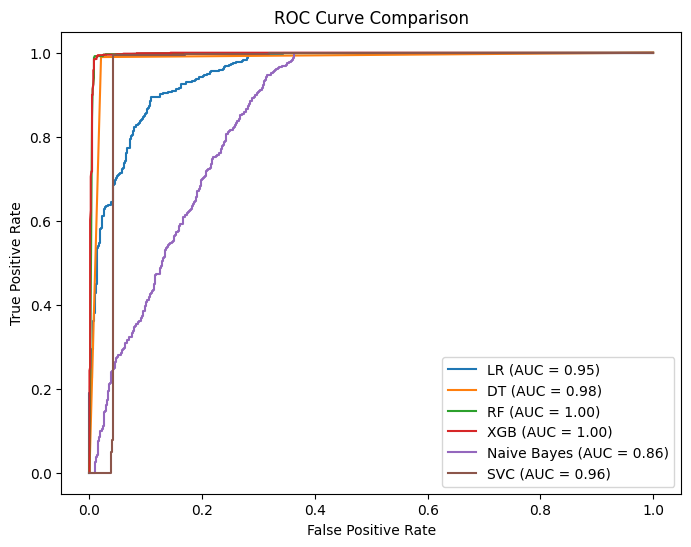

In [161]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(8, 6))
for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)[:, 1]
    else:
        y_score = model.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

In [162]:
results_df

,Model,Training Accuracy,Testing Accuracy,Confusion Matrix,Recall Score,Precision Score,F1 Score,F-Beta Score
3,XGB,0.995412,0.989106,"[[863, 14], [5, 862]]",0.989106,0.989106,0.989106,0.989106
2,RF,1.000000,0.986239,"[[860, 17], [7, 860]]",0.986239,0.986239,0.986239,0.986239
1,DT,1.000000,0.984518,"[[859, 18], [9, 858]]",0.984518,0.984518,0.984518,0.984518
5,SVC,0.898767,0.896216,"[[698, 179], [2, 865]]",0.896216,0.896216,0.896216,0.896216
0,LR,0.860338,0.866972,"[[809, 68], [164, 703]]",0.866972,0.866972,0.866972,0.866972
4,Naive Bayes,0.625609,0.625573,"[[224, 653], [0, 867]]",0.625573,0.625573,0.625573,0.625573


***XGB and Random Forest Classifier are the best models with accuracies around 98%***